Referencia:
    

https://towardsdatascience.com/bbn-bayesian-belief-networks-how-to-build-them-effectively-in-python-6b7f93435bba

In [16]:
import pandas as pd # for data manipulation 
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs
import numpy as np
# for creating Bayesian Belief Networks (BBN)
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*rzutIc-oHgiOc4pIsYU6HQ.png" alt="image info" />

Using the above, we can state the relationship between variables (nodes):

- Independence: A and C are independent of each other. So are B and C. This is because knowing whether C has happened does not change our knowledge about A or B and vice versa.
- Dependence: B is dependent on A since A is the parent of B. This relationship can be written as a conditional probability: P(B|A). D is also dependent on other variables, and in this case, it depends on two of them — B and C. Again, this can be written as a conditional probability: P(D|B,C).
- Conditional Independence: D is considered conditionally independent of A. This is because as soon as we know whether event B has happened, A becomes irrelevant from the perspective of D. In other words, the following is true: P(D|B,A) = P(D|B).

In [2]:
# Set Pandas options to display more columns
pd.options.display.max_columns=50

# Read in the weather data csv
df=pd.read_csv('./Data/weatherAUS.csv', encoding='utf-8')

# Drop records where target RainTomorrow=NaN
df=df[pd.isnull(df['RainTomorrow'])==False]

# For other columns with missing values, fill them in with column mean
df=df.fillna(df.mean())

In [5]:
# Create bands for variables that we want to use in the model
df['WindGustSpeedCat']=df['WindGustSpeed'].apply(lambda x: '0.<=40'   if x<=40 else
                                                            '1.40-50' if 40<x<=50 else '2.>50')
df['Humidity9amCat']=df['Humidity9am'].apply(lambda x: '1.>60' if x>60 else '0.<=60')
df['Humidity3pmCat']=df['Humidity3pm'].apply(lambda x: '1.>60' if x>60 else '0.<=60')

In [18]:
np.unique?

In [29]:
for condicion in np.unique(df["Humidity9amCat"]):
    subset = df.loc[df["Humidity9amCat"] == condicion]
    probs = subset["Humidity3pmCat"].value_counts(normalize=True).sort_index()
    print(probs)

0.<=60    0.92827
1.>60     0.07173
Name: Humidity3pmCat, dtype: float64
0.<=60    0.557602
1.>60     0.442398
Name: Humidity3pmCat, dtype: float64


In [12]:
# Show a snaphsot of data
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,WindGustSpeedCat,Humidity9amCat,Humidity3pmCat
0,2008-12-01,Albury,13.4,22.9,0.6,5.469824,7.624853,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.000000,4.503167,16.9,21.8,No,No,1.40-50,1.>60,0.<=60
1,2008-12-02,Albury,7.4,25.1,0.0,5.469824,7.624853,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,4.437189,4.503167,17.2,24.3,No,No,1.40-50,0.<=60,0.<=60
2,2008-12-03,Albury,12.9,25.7,0.0,5.469824,7.624853,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,4.437189,2.000000,21.0,23.2,No,No,1.40-50,0.<=60,0.<=60
3,2008-12-04,Albury,9.2,28.0,0.0,5.469824,7.624853,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,4.437189,4.503167,18.1,26.5,No,No,0.<=40,0.<=60,0.<=60
4,2008-12-05,Albury,17.5,32.3,1.0,5.469824,7.624853,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,No,No,1.40-50,1.>60,0.<=60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,2017-06-20,Uluru,3.5,21.8,0.0,5.469824,7.624853,E,31.0,ESE,E,15.0,13.0,59.0,27.0,1024.7,1021.2,4.437189,4.503167,9.4,20.9,No,No,0.<=40,0.<=60,0.<=60
145455,2017-06-21,Uluru,2.8,23.4,0.0,5.469824,7.624853,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,4.437189,4.503167,10.1,22.4,No,No,0.<=40,0.<=60,0.<=60
145456,2017-06-22,Uluru,3.6,25.3,0.0,5.469824,7.624853,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,4.437189,4.503167,10.9,24.5,No,No,0.<=40,0.<=60,0.<=60
145457,2017-06-23,Uluru,5.4,26.9,0.0,5.469824,7.624853,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,4.437189,4.503167,12.5,26.1,No,No,0.<=40,0.<=60,0.<=60


Setting up Bayesian Belief Network

Now that we have all the libraries and data ready, it is time to set up a BBN. The first stage requires us to define nodes.

In [30]:
# Create nodes by manually typing in probabilities
H9am = BbnNode(Variable(0, 'H9am', ['<=60', '>60']), [0.30658, 0.69342])
H3pm = BbnNode(Variable(1, 'H3pm', ['<=60', '>60']), [0.92827, 0.07173, 
                                                      0.55760, 0.44240])
W = BbnNode(Variable(2, 'W', ['<=40', '40-50', '>50']), [0.58660, 0.24040, 0.17300])
RT = BbnNode(Variable(3, 'RT', ['No', 'Yes']), [0.92314, 0.07686, 
                                                0.89072, 0.10928, 
                                                0.76008, 0.23992, 
                                                0.64250, 0.35750, 
                                                0.49168, 0.50832, 
                                                0.32182, 0.67818])

In [31]:
df["Humidity9amCat"].value_counts(normalize=True).sort_index()

0.<=60    0.306583
1.>60     0.693417
Name: Humidity9amCat, dtype: float64

# Se puede utilizar esta función para calcular las tablas de probabilidad condicional

In [109]:
def probs(data, child, parent1=None, parent2=None):
    if parent1==None:
        # Calculate probabilities
        prob=pd.crosstab(data[child], 'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
    elif parent1!=None:
            # Check if child node has 1 parent or 2 parents
            if parent2==None:
                # Caclucate probabilities
                prob=pd.crosstab(data[parent1],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
            else:    
                # Caclucate probabilities
                prob=pd.crosstab([data[parent1],data[parent2]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else: print("Error in Probability Frequency Calculations")
    return prob

In [144]:
# Create nodes by using our earlier function to automatically calculate probabilities
H9am = BbnNode(Variable(0, 'H9am', ['<=60', '>60']), probs(df, child='Humidity9amCat'))
H3pm = BbnNode(Variable(1, 'H3pm', ['<=60', '>60']), probs(df, child='Humidity3pmCat', parent1='Humidity9amCat'))
W = BbnNode(Variable(2, 'W', ['<=40', '40-50', '>50']), probs(df, child='WindGustSpeedCat'))
RT = BbnNode(Variable(3, 'RT', ['No', 'Yes']), probs(df, child='RainTomorrow', parent1='Humidity3pmCat', parent2='WindGustSpeedCat'))

# Create Network
bbn = Bbn() \
    .add_node(H9am) \
    .add_node(H3pm) \
    .add_node(W) \
    .add_node(RT) \
    .add_edge(Edge(H9am, H3pm, EdgeType.DIRECTED)) \
    .add_edge(Edge(H3pm, RT, EdgeType.DIRECTED)) \
    .add_edge(Edge(W, RT, EdgeType.DIRECTED))

# Convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)

Now, we want to draw the graph to check that we have set it up as intended:

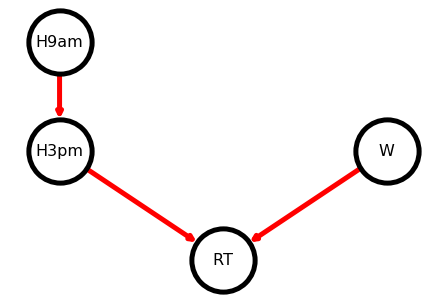

In [138]:
# Set node positions
pos = {0: (-1, 2), 1: (-1, 0.5), 2: (1, 0.5), 3: (0, -1)}

# Set options for graph looks
options = {
    "font_size": 16,
    "node_size": 4000,
    "node_color": "white",
    "edgecolors": "black",
    "edge_color": "red",
    "linewidths": 5,
    "width": 5,}
    
# Generate graph
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Update margins and print the graph
ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()

In [145]:
# Define a function for printing marginal probabilities
def print_probs():
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node)
        print("Values:")
        print(potential)
        print('----------------')
        
# Use the above function to print marginal probabilities
print_probs()

Node: 1|H3pm|<=60,>60
Values:
1=<=60|0.67124
1=>60|0.32876
----------------
Node: 0|H9am|<=60,>60
Values:
0=<=60|0.30658
0=>60|0.69342
----------------
Node: 2|W|<=40,40-50,>50
Values:
2=<=40|0.58660
2=40-50|0.24040
2=>50|0.17300
----------------
Node: 3|RT|No,Yes
Values:
3=No|0.77655
3=Yes|0.22345
----------------


As you can see, this gives us the likelihood of each event occurring with a “Rain Tomorrow (RT)” probability of 22%. While this is cool, we could have got the same 22% probability by looking at the frequency of the “RainTomorrow” variable in our original dataset.

Said that the following step is where we get a lot of value out of our BBN. We can pass evidence into BBN and see how that affects probabilities for every node in the network.

Let’s say it is 9 am right now, and we have measured the humidity outside. It says 72, which obviously belongs to the “>60” band. Hence, let’s pass this evidence into the BBN and see what happens. Note, I have created another small function to help us with that.

In [161]:
# To add evidence of events that happened so probability distribution can be recalculated
def evidence(nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    join_tree.set_observation(ev)
    
# Use above function to add evidence
evidence('H9am', '>60', 0)

# Print marginal probabilities
print_probs()

Node: 1|H3pm|<=60,>60
Values:
1=<=60|0.55760
1=>60|0.44240
----------------
Node: 0|H9am|<=60,>60
Values:
0=<=60|0.00000
0=>60|1.00000
----------------
Node: 2|W|<=40,40-50,>50
Values:
2=<=40|0.58660
2=40-50|0.24040
2=>50|0.17300
----------------
Node: 3|RT|No,Yes
Values:
3=No|0.73833
3=Yes|0.26167
----------------


In [162]:
join_tree.evidences

{1: {'<=60': <pybbn.graph.potential.Potential at 0x7f3a98b052e8>,
  '>60': <pybbn.graph.potential.Potential at 0x7f3a98b05940>},
 0: {'<=60': <pybbn.graph.potential.Potential at 0x7f3a98b05438>,
  '>60': <pybbn.graph.potential.Potential at 0x7f3a98a7d128>},
 2: {'<=40': <pybbn.graph.potential.Potential at 0x7f3a98a7db38>,
  '40-50': <pybbn.graph.potential.Potential at 0x7f3a98a7d3c8>,
  '>50': <pybbn.graph.potential.Potential at 0x7f3a98a7d160>},
 3: {'No': <pybbn.graph.potential.Potential at 0x7f3a98a7d208>,
  'Yes': <pybbn.graph.potential.Potential at 0x7f3a98bd7320>}}

As you can see, “Humidity9am>60” is now equal to 100%, and the likelihood of “Humidity3pm>60” has increased from 32.8% to 44.2%. At the same time, the chance of “RainTomorrow” has gone up to 26.1%.

Also, note how probabilities for “WindGustSpeed” did not change since “W” and “H9am” are independent of each other.

You can run the same evidence code one more time to remove the evidence from the network. After that, let’s pass two pieces of evidence for “H3pm” and “W.”

In [133]:
# Add more evidence
evidence('ev2', 'H3pm', '>60', 1.0)
print_probs()

Node: 1|H3pm|<=60,>60
Values:
1=<=60|0.00000
1=>60|1.00000
----------------
Node: 0|H9am|<=60,>60
Values:
0=<=60|0.00000
0=>60|1.00000
----------------
Node: 2|W|<=40,40-50,>50
Values:
2=<=40|0.58660
2=40-50|0.24040
2=>50|0.17300
----------------
Node: 3|RT|No,Yes
Values:
3=No|0.55077
3=Yes|0.44923
----------------


In [134]:
evidence('ev3', 'W', '>50', 1.0)
# Print marginal probabilities
print_probs()

Node: 1|H3pm|<=60,>60
Values:
1=<=60|0.00000
1=>60|1.00000
----------------
Node: 0|H9am|<=60,>60
Values:
0=<=60|0.00000
0=>60|1.00000
----------------
Node: 2|W|<=40,40-50,>50
Values:
2=<=40|0.00000
2=40-50|0.00000
2=>50|1.00000
----------------
Node: 3|RT|No,Yes
Values:
3=No|0.32182
3=Yes|0.67818
----------------


Unsurprisingly, this tells us that the chance of rain tomorrow has gone up to 67.8%. Note how “H9am” probabilities also changed, which tells us that despite us only measuring humidity at 3 pm, we are 93% certain that humidity was also above 60 at 9 am this morning.

There are many use cases for Bayesian Belief Networks, from helping to diagnose diseases to real-time predictions of a race outcome.

You can also build BBNs to help you with marketing decisions. Say, I may want to know how likely this article is to reach 10K views. Hence, I can build a BBN to tell me the probability of certain events occurring, such as posting a link to this article on Twitter and then evaluating how this probability changes as I get ten retweets.

At the end of the day, the possibilities are almost limitless, with the ability to generate real-time predictions that automatically update the entire network as soon as new evidence is introduced.

I hope you found Bayesian Belief Networks just as exciting as I did. Feel free to reach out if you have any questions or suggestions. Thanks for reading!